# This Jupyter notebook contains the MD-score analysis performed in the Steinparzer et al. 2018 manuscript 

In this notebook is a walkthrough of the analysis of GRO-Seq and PRO-Seq data from CDK8 analog sensitive human cells or MEFs (mouse) treated with IFN. The basic computational analysis consists of performing the MD-score analysis on the the top 20% most differentially transcribed enhancer RNAs. 

Pipeline inputs:
1. Bam files corresponding to samples of interest
2. Bed files of enhancer RNA regions (obtained from Tfit or elsewhere)

Walkthrough of pipeline:
1. Intersect bed files originitating from replicates and merge bed files originitating from conditions
2. Count reads mapping to the master bed file which has all high confidence regions
3. Perform DESeq2 analysis to obtain p-values of differential transcription
4. Pull out top 20% of differentially transcribed regions
5. Determine which of the 20% originitate from each sample
6. Perform MD-score analysis on these regions
7. Measure differential MD-Score between comparisons of interest

## Imports and path specifications

In [1]:
import os
import sys
import subprocess
import math
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

#Path to Steinparzer2018 github repository
#git clone https://github.com/jdrubin91/Steinparzer2018.git
src_path = '/Users/joru1876/InterferonResponseJupyter/Steinparzer2018/'
sys.path.insert(0, src_path)

#Path to the MDS package src (Azofeifa)
#git clone https://github.com/azofeifa/MDS.git
MDS_src = '/scratch/Users/joru1876/MDS/src/MDS'

#Path to installed bedtools binaries
bedtools_intersect='/opt/bedtools/2.25.0/bin/intersectBed'
bedtools_sort='/opt/bedtools/2.25.0/bin/sortBed'
bedtools_merge='/opt/bedtools/2.25.0/bin/mergeBed'
bedtools_multicov='/opt/bedtools/2.25.0/bin/multiBamCov'



## Data inputs

Raw data should be input in the form of a python dictionary.

ex:
```python
raw_data = {'sample_name': [('full/path/to/bamrep1', 'full/path/to/bamrep2'), 
                            ('full/path/to/bedrep1', 'full/path/to/bedrep2')]}
```
Where dictionary keys (ex. 'sample_name') are unique sample identifiers, and dictionary values are a list of tuples where the first tuple contains full paths to all bam replicates (comma separated) and the second tuple contains full paths to all bed replicates.
***
The comparisons variable refers to the desired sample comparisons to perform. This should be a list of tuples.

ex:
```python
comparisons = [('sample1', 'sample2'),
               ('sample3', 'sample4')]
```
Where each sample corresponds to a 'sample_name' within the raw_data python dictionary

In [2]:
bamdir = '/scratch/Users/joru1876/Taatjes/InterferonMouse/PROSEQ/All_cat/Mapped_Nextflow/mapped/bams/'
beddir = '/scratch/Users/joru1876/Taatjes/InterferonMouse/PROSEQ/All_cat/Mapped_Nextflow/mapped/Tfit/'
bamdir2 = '/scratch/Users/joru1876/Taatjes/InterferonMouse/171026_NB501447_0180_fastq_IRISREP2/Demux/Taatjes-374/trimmed/flipped/bowtie2/sortedbam/'
bamdir3 = '/scratch/Users/joru1876/Taatjes/InterferonMouse/161220_K00262_0062_BHH7CHBBXX_IRISREP1/trimmed/flipped/bowtie2_first_run/sortedbam/'
beddir2 = '/scratch/Users/joru1876/Taatjes/InterferonMouse/171026_NB501447_0180_fastq_IRISREP2/Demux/Taatjes-374/trimmed/flipped/bowtie2/sortedbam/genomecoveragebed/fortdf/Tfit/REP_MERGE/'


raw_data = {'WT_DMSO_PBS':[(bamdir+'1_WT_DMSO_PBS_1.flip.trim.sorted.bam',bamdir+'2_WT_DMSO_PBS_2.flip.trim.sorted.bam'),
                         (beddir+'1_WT_DMSO_PBS_1.bidir_predictions.bed',beddir+'2_WT_DMSO_PBS_2.bidir_predictions.bed')],
           'WT_3MB_PBS':[(bamdir+'3_WT_3MB_PBS_1.flip.trim.sorted.bam',bamdir+'4_WT_3MB_PBS_2.flip.trim.sorted.bam'),
                         (beddir+'3_WT_3MB_PBS_1.bidir_predictions.bed',beddir+'4_WT_3MB_PBS_2.bidir_predictions.bed')],
           'WT_DMSO_IFN':[(bamdir+'5_WT_DMSO_IFN_1.flip.trim.sorted.bam',bamdir+'6_WT_DMSO_IFN_2.flip.trim.sorted.bam'),
                         (beddir+'5_WT_DMSO_IFN_1.bidir_predictions.bed',beddir+'6_WT_DMSO_IFN_2.bidir_predictions.bed')],
           'WT_3MB_IFN':[(bamdir+'7_WT_3MB_IFN_1.flip.trim.sorted.bam',bamdir+'8_WT_3MB_IFN_2.flip.trim.sorted.bam'),
                        (beddir+'7_WT_3MB_IFN_1.bidir_predictions.bed',beddir+'8_WT_3MB_IFN_2.bidir_predictions.bed')],
           'AS_DMSO_PBS':[(bamdir+'9_AS_DMSO_PBS_1.flip.trim.sorted.bam',bamdir+'10_AS_DMSO_PBS_2.flip.trim.sorted.bam'),
                         (beddir+'9_AS_DMSO_PBS_1.bidir_predictions.bed',beddir+'10_AS_DMSO_PBS_2.bidir_predictions.bed')],
           'AS_3MB_PBS':[(bamdir+'11_AS_3MB_PBS_2.flip.trim.sorted.bam',bamdir+'12_AS_3MB_PBS_2.flip.trim.sorted.bam'),
                        (beddir+'11_AS_3MB_PBS_1.bidir_predictions.bed',beddir+'12_AS_3MB_PBS_2.bidir_predictions.bed')],
           'AS_DMSO_IFN':[(bamdir+'13_AS_DMSO_IFN_2.flip.trim.sorted.bam',bamdir+'14_AS_DMSO_IFN_1.flip.trim.sorted.bam'),
                         (beddir+'13_AS_DMSO_IFN_2.bidir_predictions.bed',beddir+'14_AS_DMSO_IFN_1.bidir_predictions.bed')],
           'AS_3MB_IFN':[(bamdir+'15_AS_3MB_IFN_2.flip.trim.sorted.bam',bamdir+'16_AS_3MB_IFN_1.flip.trim.sorted.bam'),
                         (beddir+'15_AS_3MB_IFN_2.bidir_predictions.bed',beddir+'16_AS_3MB_IFN_1.bidir_predictions.bed')],
           'MEF_0_IFN_DMSO':[(bamdir3+'0-1_S11_L006_R1_001_trimmed.flip.fastq.bowtie2.sorted.bam',bamdir2+'0_2_S1_R1_001_trimmed.flip.fastq.bowtie2.sorted.bam'),
                             (beddir2+'JDR_Tfit-5_bidir_predictions.bed',beddir2+'JDR_Tfit-9_bidir_predictions.bed')],
           'MEF_0_IFN_CA':[(bamdir3+'O-CA-1_S12_L006_R1_001_trimmed.flip.fastq.bowtie2.sorted.bam',bamdir2+'0_CA_2_S2_R1_001_trimmed.flip.fastq.bowtie2.sorted.bam'),
                           (beddir2+'JDR_Tfit-6_bidir_predictions.bed',beddir2+'JDR_Tfit-10_bidir_predictions.bed')],
           'MEF_30_IFN_DMSO':[(bamdir3+'30-1_S15_L007_R1_001_trimmed.flip.fastq.bowtie2.sorted.bam',bamdir2+'30_2_S3_R1_001_trimmed.flip.fastq.bowtie2.sorted.bam'),
                              (beddir2+'JDR_Tfit-7_bidir_predictions.bed',beddir2+'JDR_Tfit-11_bidir_predictions.bed')],
           'MEF_30_IFN_CA':[(bamdir3+'30-CA-1_S16_L007_R1_001_trimmed.flip.fastq.bowtie2.sorted.bam',bamdir2+'30_CA_2_S4_R1_001_trimmed.flip.fastq.bowtie2.sorted.bam'),
                            (beddir2+'JDR_Tfit-8_bidir_predictions.bed',beddir2+'JDR_Tfit-12_bidir_predictions.bed')]}

comparisons = [('WT_3MB_PBS', 'WT_3MB_IFN'),
               ('WT_3MB_PBS', 'AS_3MB_IFN'),
               ('WT_3MB_IFN', 'AS_3MB_IFN'),
               ('WT_3MB_PBS', 'AS_3MB_PBS'),
               ('MEF_0_IFN_DMSO', 'MEF_30_IFN_DMSO'),
               ('MEF_0_IFN_DMSO', 'MEF_0_IFN_CA'),
               ('MEF_30_IFN_DMSO', 'MEF_30_IFN_CA')]


output_folder='/Users/joru1876/InterferonResponseJupyter/Steinparzer2018/Data/'

## Calculate differential transcription of regions. 

This module encompasses steps 1-3 of the pipeline.

<b>Warning:</b> This section can take a while (depending on how many comparisons are specified) but only needs to be done once per comparison to generate appropriate ranked bed files.

In [12]:
from modules import differential_transcription

differential_transcription(comparisons=comparisons, raw_data=raw_data, 
                                bedtools_intersect=bedtools_intersect, 
                                bedtools_multicov=bedtools_multicov, bedtools_merge=bedtools_merge, 
                                bedtools_sort=bedtools_sort, output_folder=output_folder)

Intersecting bed file replicates...
	 WT_3MB_PBS
	 WT_3MB_IFN
	 WT_3MB_PBS
	 AS_3MB_IFN
	 WT_3MB_IFN
	 AS_3MB_IFN
	 WT_3MB_PBS
	 AS_3MB_PBS
	 MEF_0_IFN_DMSO
	 MEF_30_IFN_DMSO
	 MEF_0_IFN_DMSO
	 MEF_0_IFN_CA
	 MEF_30_IFN_DMSO
	 MEF_30_IFN_CA
Merging bed files across conditions...
	 WT_3MB_PBS vs. WT_3MB_IFN
	 WT_3MB_PBS vs. AS_3MB_IFN
	 WT_3MB_IFN vs. AS_3MB_IFN
	 WT_3MB_PBS vs. AS_3MB_PBS
	 MEF_0_IFN_DMSO vs. MEF_30_IFN_DMSO
	 MEF_0_IFN_DMSO vs. MEF_0_IFN_CA
	 MEF_30_IFN_DMSO vs. MEF_30_IFN_CA
Counting reads over merged regions using bam files...
	 WT_3MB_PBS vs. WT_3MB_IFN
	 WT_3MB_PBS vs. AS_3MB_IFN
	 WT_3MB_IFN vs. AS_3MB_IFN
	 WT_3MB_PBS vs. AS_3MB_PBS
	 MEF_0_IFN_DMSO vs. MEF_30_IFN_DMSO
	 MEF_0_IFN_DMSO vs. MEF_0_IFN_CA
	 MEF_30_IFN_DMSO vs. MEF_30_IFN_CA
Performing DE-Seq2 analysis on comparisons...
	 WT_3MB_PBS vs. WT_3MB_IFN
	 WT_3MB_PBS vs. AS_3MB_IFN
	 WT_3MB_IFN vs. AS_3MB_IFN
	 WT_3MB_PBS vs. AS_3MB_PBS
	 MEF_0_IFN_DMSO vs. MEF_30_IFN_DMSO
	 MEF_0_IFN_DMSO vs. MEF_0_IFN_CA

## Perform MDS analysis using top 20% of differentially transcribed regions

This module encompasses steps 4-6 of the pipeline. 

<b>Notes: </b>
1. A user may change the 20% to a different number or to a DE-Seq2 p-value cutoff
2. Comparisons must be split up by species to perform MDS analysis. In our case, we have mouse and human data

In [3]:
from modules import MDS_analysis

#Specify the percent of regions to retain
percentage_rank_cutoff=0.2
pval_cutoff=False

#------------Human Data--------------
comparisons = [('WT_3MB_PBS', 'WT_3MB_IFN'),
               ('WT_3MB_PBS', 'AS_3MB_IFN'),
               ('WT_3MB_IFN', 'AS_3MB_IFN'),
               ('WT_3MB_PBS', 'AS_3MB_PBS')]
fasta_file = '/scratch/Shares/public/genomes/Homo_sapiens/UCSC/hg38/Sequence/WholeGenomeFasta/genome.fa'
PSSM_DB = '/scratch/Users/joru1876/MDS/PSSM_DB/HOCOMOCO_v11_human.txt'
MDS_analysis(comparisons=comparisons, output_folder=output_folder, pval_cutoff=pval_cutoff, 
                    percentage_rank_cutoff=percentage_rank_cutoff, bedtools_intersect=bedtools_intersect, 
                    MDS_src=MDS_src, fasta_file=fasta_file, PSSM_DB=PSSM_DB)

#------------Mouse Data--------------
comparisons = [('MEF_0_IFN_DMSO', 'MEF_30_IFN_DMSO'),
               ('MEF_0_IFN_DMSO', 'MEF_0_IFN_CA'),
               ('MEF_30_IFN_DMSO', 'MEF_30_IFN_CA')]
fasta_file = '/scratch/Shares/public/genomes/Mus_musculus/UCSC/mm10/Sequence/WholeGenomeFasta/genome.fa'
PSSM_DB = '/scratch/Users/joru1876/MDS/PSSM_DB/HOCOMOCO_v11_mouse.txt'
MDS_analysis(comparisons=comparisons, output_folder=output_folder, pval_cutoff=pval_cutoff, 
                    percentage_rank_cutoff=percentage_rank_cutoff, bedtools_intersect=bedtools_intersect, 
                    MDS_src=MDS_src, fasta_file=fasta_file, PSSM_DB=PSSM_DB)

Retrieving individual regions from merged bed file...
	 WT_3MB_PBS vs. WT_3MB_IFN
	 WT_3MB_PBS vs. AS_3MB_IFN
	 WT_3MB_IFN vs. AS_3MB_IFN
	 WT_3MB_PBS vs. AS_3MB_PBS
Performing MDS analysis for each condition from given regions...
	 WT_3MB_PBS vs. WT_3MB_IFN : WT_3MB_PBS
	 WT_3MB_PBS vs. WT_3MB_IFN : WT_3MB_IFN
	 WT_3MB_PBS vs. AS_3MB_IFN : WT_3MB_PBS
	 WT_3MB_PBS vs. AS_3MB_IFN : AS_3MB_IFN
	 WT_3MB_IFN vs. AS_3MB_IFN : WT_3MB_IFN
	 WT_3MB_IFN vs. AS_3MB_IFN : AS_3MB_IFN
	 WT_3MB_PBS vs. AS_3MB_PBS : WT_3MB_PBS
	 WT_3MB_PBS vs. AS_3MB_PBS : AS_3MB_PBS
Retrieving individual regions from merged bed file...
	 MEF_0_IFN_DMSO vs. MEF_30_IFN_DMSO
	 MEF_0_IFN_DMSO vs. MEF_0_IFN_CA
	 MEF_30_IFN_DMSO vs. MEF_30_IFN_CA
Performing MDS analysis for each condition from given regions...
	 MEF_0_IFN_DMSO vs. MEF_30_IFN_DMSO : MEF_0_IFN_DMSO
	 MEF_0_IFN_DMSO vs. MEF_30_IFN_DMSO : MEF_30_IFN_DMSO
	 MEF_0_IFN_DMSO vs. MEF_0_IFN_CA : MEF_0_IFN_DMSO
	 MEF_0_IFN_DMSO vs. MEF_0_IFN_CA : MEF_0_IFN_CA
	 MEF_

## Differential MDS analysis

Step 7 of pipeline. Generates a file for each desired comparison that can then be used for plotting purposes.

In [3]:
from modules import differential_MDS

comparisons = [('WT_3MB_PBS', 'WT_3MB_IFN'),
               ('WT_3MB_PBS', 'AS_3MB_IFN'),
               ('WT_3MB_IFN', 'AS_3MB_IFN'),
               ('WT_3MB_PBS', 'AS_3MB_PBS'),
               ('MEF_0_IFN_DMSO', 'MEF_30_IFN_DMSO'),
               ('MEF_0_IFN_DMSO', 'MEF_0_IFN_CA'),
               ('MEF_30_IFN_DMSO', 'MEF_30_IFN_CA')]

differential_MDS(comparisons=comparisons, output_folder=output_folder)

Performing differential MDS analysis...
	 WT_3MB_PBS vs. WT_3MB_IFN
	 WT_3MB_PBS vs. AS_3MB_IFN
	 WT_3MB_IFN vs. AS_3MB_IFN
	 WT_3MB_PBS vs. AS_3MB_PBS
	 MEF_0_IFN_DMSO vs. MEF_30_IFN_DMSO
	 MEF_0_IFN_DMSO vs. MEF_0_IFN_CA
	 MEF_30_IFN_DMSO vs. MEF_30_IFN_CA


## MD-Score MA plots

With the MD-Score analysis, we first plot MA-plots for all comparisons. Labeling in orange any TFs that have "STA" in their name (encompasses all STAT motifs including STA5A/B)

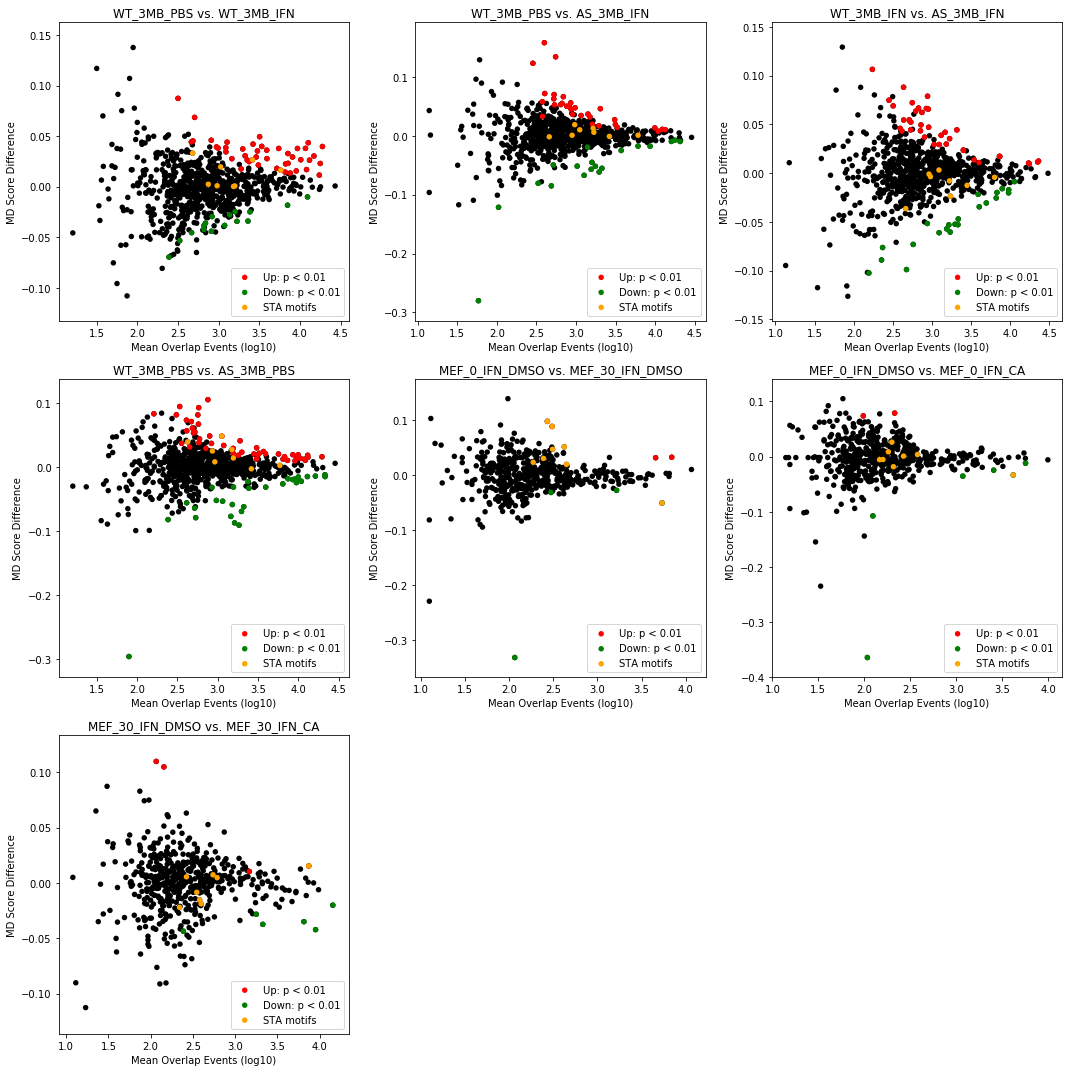

In [3]:
from modules import MA_plot_figure

MA_plot_figure(comparisons=comparisons, output_folder=output_folder, save=False, label="STA")

Data points for any comparison can be printed as well using a p-value cutoff, the top n motifs, or a specific motif name:

In [6]:
from functions import print_MDS

print('MEF_0_IFN_DMSO', 'vs.', 'MEF_30_IFN_DMSO')

print("\n","pval < 0.01")
print_MDS(condition1='MEF_0_IFN_DMSO', condition2='MEF_30_IFN_DMSO', output_folder=output_folder, 
                pval_cut=0.01, n=None, motif=None)

print("\n","Top 10 significant motifs")
print_MDS(condition1='MEF_0_IFN_DMSO', condition2='MEF_30_IFN_DMSO', output_folder=output_folder, 
                pval_cut=None, n=10, motif=None)

print("\n","STAT motifs")
print_MDS(condition1='MEF_0_IFN_DMSO', condition2='MEF_30_IFN_DMSO', output_folder=output_folder, 
                pval_cut=None, n=None, motif='STA')

MEF_0_IFN_DMSO vs. MEF_30_IFN_DMSO

 pval < 0.01
TF	Log10Events	MDS_difference	p-value
STAT1_0 3.7323937598229686 -0.05058005087013298 1.447388377e-18
SMCA5_0 2.064457989226918 -0.33096623044583134 4.69056549398e-08
SP5_0 3.8421097634406096 0.03240500119451309 1.32167218281e-07
WT1_0 3.6598686816626795 0.03152550131653781 8.88920349575e-05
STA5B_0 2.487845120111435 0.08825061224605116 0.000898855154129
STAT1_1 2.4337698339248655 0.09747256455514115 0.00110131823092
HXD9_0 2.4742162640762553 -0.03148587027083127 0.0044586503742
ETS2_0 3.217878578027433 -0.027679960617691943 0.00573023263208

 Top 10 significant motifs
TF	Log10Events	MDS_difference	p-value
STAT1_0 3.7323937598229686 -0.05058005087013298 1.447388377e-18
SMCA5_0 2.064457989226918 -0.33096623044583134 4.69056549398e-08
SP5_0 3.8421097634406096 0.03240500119451309 1.32167218281e-07
WT1_0 3.6598686816626795 0.03152550131653781 8.88920349575e-05
STA5B_0 2.487845120111435 0.08825061224605116 0.000898855154129
STAT1_1 2.43376983

## MD-Score heatmaps

Next, we plot heatmaps for a specific TF (STAT1 in our case) to compare differences of a single TF across treatments.

<b>Note: Here we must separate between human and mouse again</b>

STAT1_HUMAN.H11MO.0.A


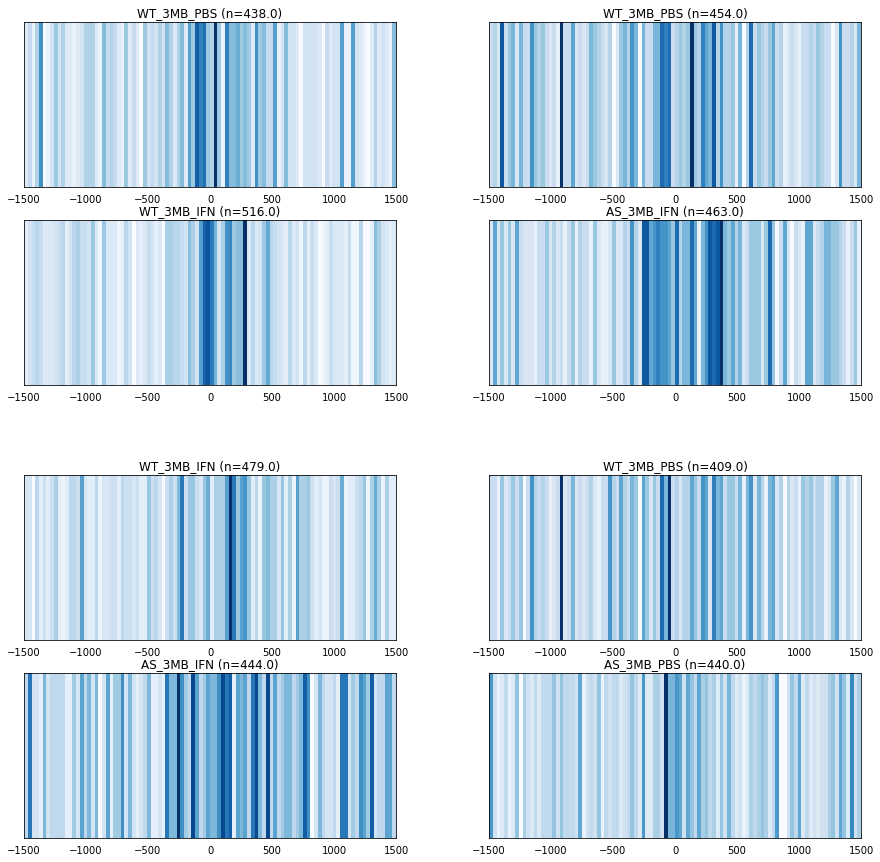

STAT1_MOUSE.H11MO.1.A


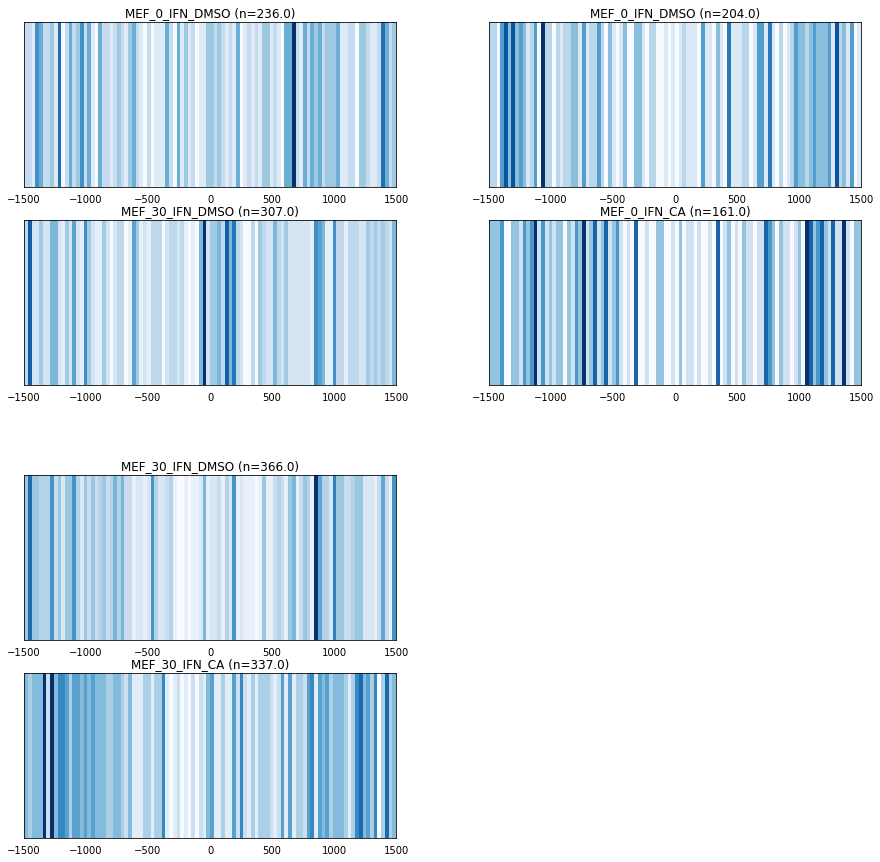

In [3]:
from modules import heatmap_plot_figure

#------------Human Data--------------
comparisons = [('WT_3MB_PBS', 'WT_3MB_IFN'),
               ('WT_3MB_PBS', 'AS_3MB_IFN'),
               ('WT_3MB_IFN', 'AS_3MB_IFN'),
               ('WT_3MB_PBS', 'AS_3MB_PBS')]

heatmap_plot_figure(comparisons=comparisons, output_folder=output_folder, save=False, 
                        motif='STAT1_HUMAN.H11MO.0.A')

#------------Mouse Data--------------
comparisons = [('MEF_0_IFN_DMSO', 'MEF_30_IFN_DMSO'),
               ('MEF_0_IFN_DMSO', 'MEF_0_IFN_CA'),
               ('MEF_30_IFN_DMSO', 'MEF_30_IFN_CA')]

heatmap_plot_figure(comparisons=comparisons, output_folder=output_folder, save=False, 
                        motif='STAT1_MOUSE.H11MO.1.A')

## Plot customization

Either plot can be further customized using functions contained within the "functions" package.

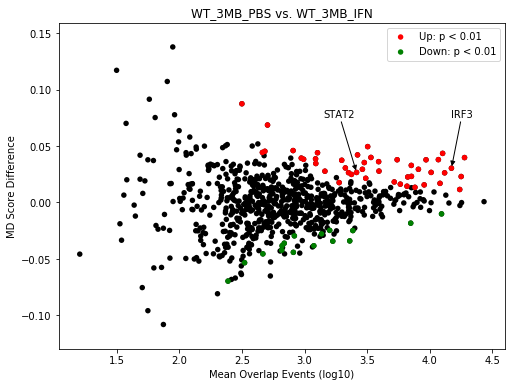

TF	Log10Events	MDS_difference	p-value
PITX2_0 3.969672126423837 0.037814368503878565 0.0
IKZF1_0 4.0682415369570455 0.03793480409074647 0.0
ZN770_1 4.102159183243685 0.04348154495578796 0.0
IRF3_0 4.172486169686935 0.030360823122838134 0.0
ZN770_0 4.2771161994083755 0.03975496945337535 0.0
HMGA1_0 4.118115856314559 0.026249230915350214 5.20250509339e-13
ZN121_0 4.01040597262518 0.02663959763151064 6.86339873823e-13
PAX5_0 3.851991747962157 0.0328365237490237 2.59925414525e-12
MAZ_0 4.250261382664085 0.022979155241395852 4.80770978584e-12
RARB_0 3.738939031203479 0.03784898829536594 6.38602393188e-09
RXRB_0 3.529494518433277 0.03988041456410579 3.31345559879e-08
RARG_1 3.9088601730172763 0.029393780617768 4.01497473046e-08
FOXL1_0 3.591175950311791 0.03615156802297534 1.02346936259e-07
THA_0 3.476686742945645 0.03535504910633089 1.99436348769e-07
RXRA_1 3.422589839851482 0.04213444454145959 2.85988035476e-07
RARA_0 3.5035183127240748 0.04946895532208799 4.42388644828e-07
FOXJ2_0 3.85311

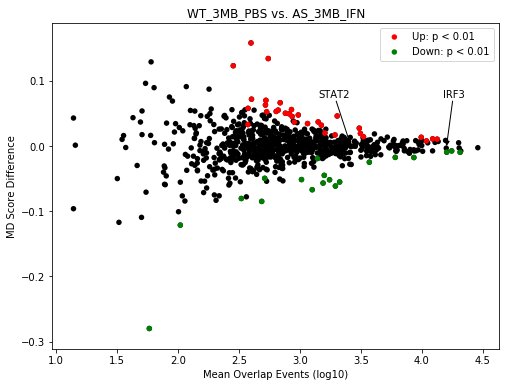

TF	Log10Events	MDS_difference	p-value
P73_0 2.7415455167762093 0.1341019767109293 1.33265184443e-07
P63_0 2.5998830720736876 0.15804956180974547 2.4206618745e-06
BRCA1_0 3.3061032087275852 0.04599253359139861 2.59022141247e-06
MIXL1_0 2.718501688867274 0.06280162715684408 5.87359873561e-06
PITX2_0 3.994317152669636 0.01333439876747232 9.67375052952e-06
FOSL2_0 3.2913688504515823 -0.06147601101940123 7.14270513096e-05
MESP1_0 3.4871383754771865 0.027271202294973554 0.000153693127885
FOSL1_0 3.326335860928751 -0.05525640551860364 0.000213948798035
ZNF8_0 2.83916368291465 0.06632770066136541 0.000227669820362
HMGA2_0 2.021189299069938 -0.12145293417130198 0.00026061778341
FOS_0 3.101575246255933 -0.06711504499327323 0.000337730223853
IKZF1_0 4.0881715398643514 0.010883406682652462 0.000353659558159
ZN770_1 4.125172107179599 0.010396801134800406 0.000449520531751
DBP_0 2.728353782021228 0.05242007420545701 0.000555730869337
LHX8_0 2.575764980536719 0.05771246207375336 0.000560771357744
ZN2

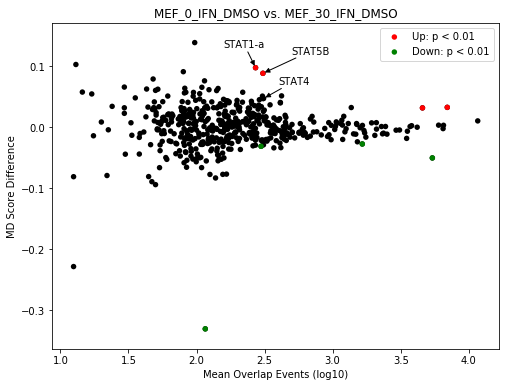

TF	Log10Events	MDS_difference	p-value
STAT1_0 3.7323937598229686 -0.05058005087013298 1.447388377e-18
SMCA5_0 2.064457989226918 -0.33096623044583134 4.69056549398e-08
SP5_0 3.8421097634406096 0.03240500119451309 1.32167218281e-07
WT1_0 3.6598686816626795 0.03152550131653781 8.88920349575e-05
STA5B_0 2.487845120111435 0.08825061224605116 0.000898855154129
STAT1_1 2.4337698339248655 0.09747256455514115 0.00110131823092
HXD9_0 2.4742162640762553 -0.03148587027083127 0.0044586503742
ETS2_0 3.217878578027433 -0.027679960617691943 0.00573023263208


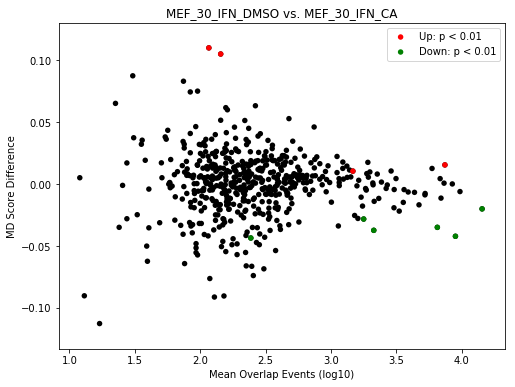

TF	Log10Events	MDS_difference	p-value
SP5_0 3.9525260715561386 -0.04220252927623699 4.77835508589e-14
MAZ_0 4.156261343464525 -0.020094106454173206 1.92878743425e-07
WT1_0 3.814014399594432 -0.034991253619283506 6.96581975474e-07
RREB1_0 3.2505419780102724 -0.028296645050814848 9.40799454062e-05
STAT1_0 3.8719813538433687 0.015374079041204476 0.000376584679552
PURA_0 3.3277674899027287 -0.03739753438888573 0.000587179967526
NR1H3_1 2.0663259253620376 0.1098014649998398 0.00345319318307
FOXJ3_0 3.168055303459139 0.010356994503706921 0.00671403571486
OVOL1_0 2.387389826338729 -0.04360619464067643 0.00870220428902
ESR2_0 2.156851901070011 0.10484500681612212 0.00956160134079


In [32]:
from functions import plot_MA, label

#Human IFN response
F = plt.figure(figsize=(8,6))
ax = F.add_subplot(111)
condition1 = 'WT_3MB_PBS'
condition2 = 'WT_3MB_IFN'

plot_MA(condition1=condition1, condition2=condition2, output_folder=output_folder, ax=ax, 
            pval_cut=0.01, label=False)

label(condition1=condition1, condition2=condition2, output_folder=output_folder, name='STAT2_0', 
            label='STAT2', xytext=(3.15, 0.075), ax=ax)

label(condition1=condition1, condition2=condition2, output_folder=output_folder, name='IRF3_0', 
            label='IRF3', xytext=(4.17, 0.075), ax=ax)

plt.legend()
plt.show()

print_MDS(condition1=condition1, condition2=condition2, output_folder=output_folder, 
                pval_cut=0.01, n=None, motif=None)

#Human IFN with CDK8AS
F = plt.figure(figsize=(8,6))
ax = F.add_subplot(111)
condition1 = 'WT_3MB_PBS'
condition2 = 'AS_3MB_IFN'

plot_MA(condition1=condition1, condition2=condition2, output_folder=output_folder, ax=ax, 
            pval_cut=0.01, label=False)

label(condition1=condition1, condition2=condition2, output_folder=output_folder, name='STAT2_0', 
            label='STAT2', xytext=(3.15, 0.075), ax=ax)

label(condition1=condition1, condition2=condition2, output_folder=output_folder, name='IRF3_0', 
            label='IRF3', xytext=(4.17, 0.075), ax=ax)

plt.legend()
plt.show()

print_MDS(condition1=condition1, condition2=condition2, output_folder=output_folder, 
                pval_cut=0.01, n=None, motif=None)

#Mouse IFN response
F = plt.figure(figsize=(8,6))
ax = F.add_subplot(111)
condition1 = 'MEF_0_IFN_DMSO'
condition2 = 'MEF_30_IFN_DMSO'

plot_MA(condition1=condition1, condition2=condition2, output_folder=output_folder, ax=ax, 
            pval_cut=0.01, label=False)
label(condition1=condition1, condition2=condition2, output_folder=output_folder, name='STAT1_1', 
            label='STAT1-a', xytext=(2.2,0.13), ax=ax)
label(condition1=condition1, condition2=condition2, output_folder=output_folder, name='STA5B_0', 
            label='STAT5B', xytext=(2.7,0.12), ax=ax)
label(condition1=condition1, condition2=condition2, output_folder=output_folder, name='STAT4_0', 
            label='STAT4', xytext=(2.6,0.07), ax=ax)

plt.legend()
plt.show()

print_MDS(condition1=condition1, condition2=condition2, output_folder=output_folder, 
                pval_cut=0.01, n=None, motif=None)

#Mouse IFN response with CA
F = plt.figure(figsize=(8,6))
ax = F.add_subplot(111)
condition1 = 'MEF_30_IFN_DMSO'
condition2 = 'MEF_30_IFN_CA'

plot_MA(condition1=condition1, condition2=condition2, output_folder=output_folder, ax=ax, 
            pval_cut=0.01, label=False)

plt.legend()
plt.show()

print_MDS(condition1=condition1, condition2=condition2, output_folder=output_folder, 
                pval_cut=0.01, n=None, motif=None)